# This notebook generates molecular crystal graph from pickled data from `cif2cluster_data.ipynb` descriptors



In [1]:
import numpy
numpy.__version__

'2.2.4'

In [2]:
import pandas
pandas.__version__

'2.2.3'

In [62]:
import gzip
import pickle
import urllib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw


f = 'GNN_DATA.pkl'
f = '/Users/zgt/Desktop/BMS-Capstone-CSP-GNN/no_H_data/acetam_DATA.pkl'
f = '/Users/zgt/Desktop/BMS-Capstone-CSP-GNN/acetam_GNN_DATA.pkl'

file = open(f,'rb')
#trajs = pickle.load(file)
trajs = pd.read_pickle(file)

# label_str = list(set([k.split("-")[0] for k in trajs]))


# # now build dataset
def generator():
    for index,row in trajs.iterrows():
        label = row['Label']
        traj = row['Coordinates']
        nodes = row['Descriptors']
        #for i in range(traj.shape[0]):
        yield traj, label, nodes

data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
        tf.TensorSpec(shape=(None, 24), dtype=tf.float32),  # need to change to 23 for new data
    ),
).shuffle(
    1000,
    reshuffle_each_iteration=False,  # do not change order each time (!) otherwise will contaminate
)

# # The shuffling above is really important because this dataset is in order of labels!

# val_data = data.take(100)
# test_data = data.skip(100).take(100)
# train_data = data.skip(200)

val_data = data.take(100)
test_data = data.skip(100).take(100)
train_data = data.skip(100)

In [63]:
it = iter(data)
sample = next(it)
print(sample[0])
print(sample[2])

tf.Tensor(
[[ -0.3822414   9.548675    3.6502934]
 [  0.2198035   8.794833    4.1550617]
 [  0.5460667   8.953182    5.507015 ]
 ...
 [-10.976665   -4.951715   -9.194817 ]
 [-12.37951    -5.1792145  -8.126605 ]
 [-12.325217   -3.8200572  -9.303769 ]], shape=(1020, 3), dtype=float32)
tf.Tensor(
[[1.         0.1008     0.         ... 0.13518716 0.93501973 1.0657157 ]
 [1.         0.1008     0.         ... 0.13518716 0.93501973 1.0657157 ]
 [1.         0.1008     0.         ... 0.13518716 0.93501973 1.0657157 ]
 ...
 [7.         1.4007     0.         ... 0.13518716 0.93501973 1.0657157 ]
 [8.         1.5999     1.         ... 0.13518716 0.93501973 1.0657157 ]
 [8.         1.5999     1.         ... 0.13518716 0.93501973 1.0657157 ]], shape=(1020, 24), dtype=float32)


IndexError: index 5 is out of bounds for axis 0 with size 5

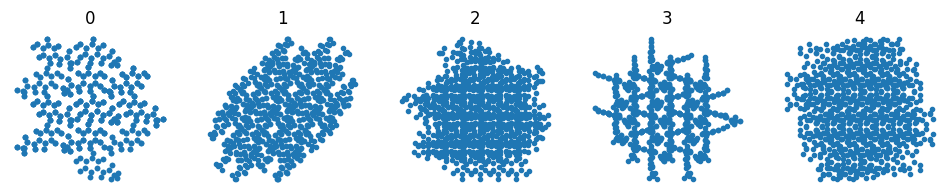

In [64]:
"""
Visualize 2D projection of 3D data
"""
fig, axs = plt.subplots(1, 5, figsize=(12, 2))
axs = axs.flatten()

# get a few example and plot them
for i, (x, y, z) in enumerate(val_data):
    # print(x[:,0])
    # print(z)
    # print(x)
    if i == 20:
        break
    axs[i].plot(x[:, 1], x[:, 2], ".")
    axs[i].set_title(str(i))
    axs[i].axis("off")


In [65]:
# this decorator speeds up the function by "compiling" it (tracing it)
# to run efficienty
@tf.function(
    reduce_retracing=True,
)
def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0]
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # one column
    qTexpand = tf.expand_dims(positions, 0)  # one row
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1])
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype)
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices



IndexError: index 5 is out of bounds for axis 0 with size 5

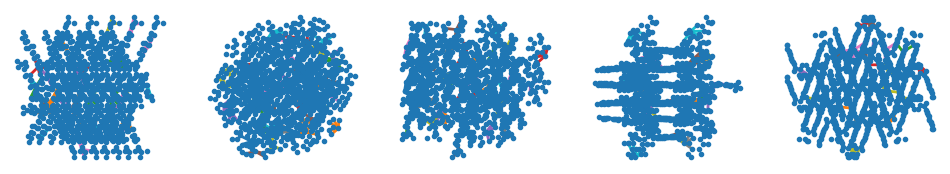

In [66]:
from matplotlib import collections

fig, axs = plt.subplots(1, 5, figsize=(12, 2))
axs = axs.flatten()
for i, (x, y, z) in enumerate(data):
    if i == 6:
        break
    e_f, e_i = get_edges(x, 6)

    # make things easier for plotting
    e_i = e_i.numpy()
    x = x.numpy()
    y = y.numpy()

    # make lines from origin to its neigbhors
    lines = []
    colors = []
    for j in range(0, x.shape[0], 23):
        # lines are [(xstart, ystart), (xend, yend)]
        lines.extend([[(x[j, 0], x[j, 1]), (x[k, 0], x[k, 1])] for k in e_i[j]])
        colors.extend([f"C{j}"] * len(e_i[j]))
    lc = collections.LineCollection(lines, linewidths=2, colors=colors)
    axs[i].add_collection(lc)
    axs[i].plot(x[:, 0], x[:, 1], ".")
    axs[i].axis("off")
    #axs[i].set_title(label_str[y])
plt.show()


In [67]:
MAX_DEGREE = 12
EDGE_FEATURES = 8
MAX_R = 15

gamma = 1
mu = np.linspace(0, MAX_R, EDGE_FEATURES)


def rbf(r):
    return tf.exp(-gamma * (r[..., tf.newaxis] - mu) ** 2)


def make_graph(x, y, n):
    edge_r, edge_i = get_edges(x, MAX_DEGREE)
    edge_features = rbf(edge_r)    
    return (n, edge_features, edge_i), y[None]


graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)


In [68]:
(n, e, nn), y = next(iter(graph_train_data))
print("Node features shape:", n.shape)
print("Edge features shape:", e.shape)
print("Edge indices shape:", nn.shape)

Node features shape: (1000, 24)
Edge features shape: (1000, 12, 8)
Edge indices shape: (1000, 12)


In [22]:
for (n, e, nn), y in graph_train_data:
    print("first node:", n[1].numpy())
    print("first node, first edge features:", e[1, 1].numpy())
    print("first node, all neighbors", nn[1].numpy())
    print("label", y.numpy())
    break


first node: [6.         1.2011     0.         0.         4.         1.7
 2.55       1.41288    1.5106332  2.         0.         1.
 2.         3.         3.         0.54551667 1.1114925  0.5969234
 0.9868546  2.5594852  0.15045092 0.8991539  0.93094814]
first node, first edge features: [1.3922130e-01 5.7945913e-01 2.4769764e-04 1.0874315e-11 4.9030192e-23
 2.2704032e-38 0.0000000e+00 0.0000000e+00]
first node, all neighbors [ 27   3 480   2  28  26 323  10 482 325 450 457]
label [1]


In [23]:
def ssp(x):
    # shifted softplus activation
    return tf.math.log(0.5 * tf.math.exp(x) + 0.5)


def make_h1(units):
    return tf.keras.Sequential([tf.keras.layers.Dense(units)])


def make_h2(units):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units, activation=ssp),
            tf.keras.layers.Dense(units, activation=ssp),
        ]
    )


def make_h3(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp), tf.keras.layers.Dense(units)]
    )


In [24]:
class SchNetModel(tf.keras.Model):
    """Implementation of SchNet Model"""

    def __init__(self, gnn_blocks, channels, label_dim, **kwargs):
        super(SchNetModel, self).__init__(**kwargs)
        self.gnn_blocks = gnn_blocks

        # build our layers
        
        self.embedding = tf.keras.layers.Embedding(89, channels-24 + 1)
        self.h1s = [make_h1(channels) for _ in range(self.gnn_blocks)]
        self.h2s = [make_h2(channels) for _ in range(self.gnn_blocks)]
        self.h3s = [make_h3(channels) for _ in range(self.gnn_blocks)]
        self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
        self.readout_l2 = tf.keras.layers.Dense(label_dim)

    def call(self, inputs):
        nodes, edge_features, edge_i = inputs
        #print(nodes.shape,edge_features.shape,edge_i.shape)
        # turn node types as index to features
        # embedded = self.embedding(nodes[:,0])
        nodes = tf.concat([self.embedding(nodes[:,0]),nodes[:,1:]],1)
        print(nodes.shape,edge_features.shape,edge_i.shape)
        for i in range(self.gnn_blocks):
            # get the node features per edge
            v_sk = tf.gather(nodes, edge_i)
            e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features)
            e_i = tf.reduce_sum(e_k, axis=1)
            nodes += self.h3s[i](e_i)
        # readout now
        nodes = self.readout_l1(nodes)
        nodes = self.readout_l2(nodes)
        return tf.reduce_mean(nodes, axis=0)


In [ ]:


small_schnet = SchNetModel(3, 32, 2)


In [28]:
for x, y in graph_test_data:
    #print(x[0])
    yhat = small_schnet(x)
    #break
    print(yhat.numpy())


(561, 30) (561, 12, 8) (561, 12)
(561, 30) (561, 12, 8) (561, 12)


/Users/zgt/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/layer.py:1387: UserWarning: Layer 'sch_net_model_1' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Dimensions must be equal, but are 30 and 31 for '{{node add}} = AddV2[T=DT_FLOAT](concat, sequential_15_1/dense_27_1/BiasAdd)' with input shapes: [561,30], [561,31].''
  warnings.warn(
/Users/zgt/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/layer.py:393: Us

InvalidArgumentError: Exception encountered when calling SchNetModel.call().

[1m{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [561,30] vs. [561,31] [Op:AddV2] name: [0m

Arguments received by SchNetModel.call():
  • inputs=('tf.Tensor(shape=(561, 23), dtype=float32)', 'tf.Tensor(shape=(561, 12, 8), dtype=float32)', 'tf.Tensor(shape=(561, 12), dtype=int32)')

In [23]:
x[0]

array([ 2.3441296 , -0.08567579,  0.70624465], dtype=float32)

In [24]:
embed(nodes[:,0])

NameError: name 'embed' is not defined

In [12]:
train_data

<_SkipDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(None, 24), dtype=tf.float32, name=None))>